In [ ]:
# import packages
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
 recall_score,classification_report,roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier # Neural Networks
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.naive_bayes import GaussianNB, MultinomialNB # Naive Bayes
from xgboost import XGBClassifier # XGBoost
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.linear_model import LogisticRegression #Logistic regression


In [ ]:
z = pd.read_csv("FimaNfipClaims-new.zip", compression="zip")

In [5]:
z.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478927 entries, 0 to 2478926
Data columns (total 40 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   agricultureStructureIndicator               float64
 1   asOfDate                                    object 
 2   baseFloodElevation                          float64
 3   basementEnclosureCrawlspace                 float64
 4   reportedCity                                object 
 5   condominiumIndicator                        object 
 6   policyCount                                 float64
 7   countyCode                                  float64
 8   communityRatingSystemDiscount               float64
 9   dateOfLoss                                  object 
 10  elevatedBuildingIndicator                   float64
 11  elevationCertificateIndicator               float64
 12  elevationDifference                         float64
 13  censusTract                

# Data Preping

## Data and Cleaning

The data from the FEMA website had a lot of features that did not have predictive power for our business case. These include ID,asOfDate and policyCount among others. The features were filtered down to 12 main features (dummies extends it to 15). Dummies were also created for variables with categorical data of more than 2. We also filtered states down to the midwest because it is the region the business plans to operate in.

To simplify our model we made some judgements in grouping values in the features.

For community rating system, we grouped the values to into rated (1) and non rated (0) with nulls changed to non rated. We used a similar method for flood zones converting them into flood zones (1) and non flood zones (0). Occupancy type 6 was not defined on the FEMA website and we could not determine what it meant, given there were relatively few observations with that value, they were removed from our observations.

RateMethod was classified as 0 for values of 0 or null which meant they did not specify an approach in underwriting the insurance product. Observations with original value of 1, which means they used manual calculation (underwritter's intuition/experience), were also categorized as zero and all other values represent different pricing methods used. These were all categorized as one.

For observations like longitude, latitude, occupancy type etc where null did not represent zero in a way that made business sense like floodzones(and non floodzones), null observations were removed. Given how large the dataset was, we did not have to worry about not having enough observations after removing nulls.

In [6]:
df = z.copy()
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478927 entries, 0 to 2478926
Data columns (total 40 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   agricultureStructureIndicator               float64
 1   asOfDate                                    object 
 2   baseFloodElevation                          float64
 3   basementEnclosureCrawlspace                 float64
 4   reportedCity                                object 
 5   condominiumIndicator                        object 
 6   policyCount                                 float64
 7   countyCode                                  float64
 8   communityRatingSystemDiscount               float64
 9   dateOfLoss                                  object 
 10  elevatedBuildingIndicator                   float64
 11  elevationCertificateIndicator               float64
 12  elevationDifference                         float64
 13  censusTract                

### Fitering for midwest states

In [7]:
df.info()
df = df[df.state.isin(['ND','MI','IL','IN','IA','MO','MN','NE','OH','WI','KS','SD'])]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478927 entries, 0 to 2478926
Data columns (total 40 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   agricultureStructureIndicator               float64
 1   asOfDate                                    object 
 2   baseFloodElevation                          float64
 3   basementEnclosureCrawlspace                 float64
 4   reportedCity                                object 
 5   condominiumIndicator                        object 
 6   policyCount                                 float64
 7   countyCode                                  float64
 8   communityRatingSystemDiscount               float64
 9   dateOfLoss                                  object 
 10  elevatedBuildingIndicator                   float64
 11  elevationCertificateIndicator               float64
 12  elevationDifference                         float64
 13  censusTract                

### Dropping irrelevant attributes for the business context

In [8]:
df.drop(columns = ['asOfDate','baseFloodElevation','basementEnclosureCrawlspace','condominiumIndicator'], inplace = True)

df.drop(columns = ['policyCount','countyCode','dateOfLoss','elevationCertificateIndicator','elevationDifference','censusTract'], inplace = True)

df.drop(columns = ['locationOfContents','lowestAdjacentGrade','lowestFloorElevation','nonProfitIndicator','obstructionType'], inplace = True)

df.drop(columns = ['originalConstructionDate','originalNBDate','smallBusinessIndicatorBuilding','yearOfLoss'], inplace = True)

### Exploring various property uses

In [9]:
print(df.iloc[:,[0,5,19]].value_counts())
print(df.iloc[:,0].value_counts())
print(df.iloc[:,5].value_counts())
print(df.iloc[:,19].value_counts())

agricultureStructureIndicator  houseWorship  primaryResidence
0.0                            0.0           0.0                 144010
                                             1.0                  85316
1.0                            0.0           0.0                    178
0.0                            1.0           0.0                     92
                                             1.0                     22
1.0                            0.0           1.0                      1
dtype: int64
0.0    229440
1.0       179
Name: agricultureStructureIndicator, dtype: int64
0.0    229505
1.0       114
Name: houseWorship, dtype: int64
0.0    144280
1.0     85339
Name: primaryResidence, dtype: int64


### **communityRatingSystemDiscount**

We converted nulls to zero.

In [10]:
# communityRatingSystemDiscount...converting non-zeros to 1
print(df.communityRatingSystemDiscount.isnull().sum())
print(df.communityRatingSystemDiscount.value_counts())
df.communityRatingSystemDiscount = df.communityRatingSystemDiscount.apply(lambda x: 1 if (x >= 0) else 0)
df.communityRatingSystemDiscount.value_counts()

159945
7.0     23638
8.0     12833
5.0     12585
6.0      8744
10.0     6458
9.0      5227
2.0       185
3.0         3
4.0         1
Name: communityRatingSystemDiscount, dtype: int64


0    159945
1     69674
Name: communityRatingSystemDiscount, dtype: int64

### floodZone changed null to zeros and for non zeros were changed to 1.

In [11]:
print('null values',df.floodZone.isna().sum())
print(df.floodZone.value_counts())
df.floodZone = df.floodZone.fillna(value=0)
df.floodZone = df.floodZone.apply(lambda x: 1 if (x != 0) else 0)

#print(df.floodZone.value_counts())

null values 23043
AE     54739
A      33345
X      27414
C      15360
B      10347
A10     6055
A03     5661
A04     4772
A20     4716
A05     4431
A07     3736
A02     3657
A17     3558
A08     3482
A06     3304
A09     2884
A13     2696
A15     2618
AO      1826
AH      1819
A11     1581
A14     1421
A16     1297
A01     1233
A19      884
D        836
A18      820
A12      671
A21      578
A99      323
AHB      170
A22      121
AOB      120
V12       12
A24       12
V10        9
A23        8
V14        8
V05        7
V09        7
A30        6
V08        6
VE         6
V11        5
AA         5
V15        4
V13        3
A25        2
V          1
Name: floodZone, dtype: int64


###  latitude and longitude (deleted blanks).


In [12]:
# Lat & Long delete blanks
df = df[pd.notnull(df.longitude)]
df = df[pd.notnull(df.latitude)]

### OccupancyType (delete 6 and null).

In [13]:
# occupancyType (delete 6 or null)
print('total obs:',len(df),'\nOccupancy type values\n',df.occupancyType.value_counts())
df = df[df.occupancyType != 6]
df = df[pd.notnull(df.occupancyType)]

df['occupancyType'] = df.occupancyType.astype('category')
df = pd.get_dummies(df,columns=['occupancyType'],drop_first=False)
#print('total obs:',len(df),'\nOccupancy type values\n',df.occupancyType.value_counts())
df.info()

total obs: 219581 
Occupancy type values
 1.0    181793
4.0     21644
2.0      6208
6.0      5271
3.0      4594
Name: occupancyType, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214239 entries, 23 to 2478921
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   agricultureStructureIndicator               214239 non-null  float64
 1   reportedCity                                214209 non-null  object 
 2   communityRatingSystemDiscount               214239 non-null  int64  
 3   elevatedBuildingIndicator                   214239 non-null  float64
 4   floodZone                                   214239 non-null  int64  
 5   houseWorship                                214239 non-null  float64
 6   latitude                                    214239 non-null  float64
 7   longitude                                   214239 non-null  float64
 

### Create y variables

* amount paid (on building + on content + on increased cost of compliance)
* Total coverage (on building + on content)
* (amount paid/total coverage)*100
* Remove variables used from dataframe

In [14]:
print('obs:',df.info())
TotalPaid = df.amountPaidOnBuildingClaim.add(df.amountPaidOnContentsClaim 
                        .add(df.amountPaidOnIncreasedCostOfComplianceClaim,fill_value=0)
                        ,fill_value=0)


Totalcov = df.totalBuildingInsuranceCoverage.add(df.totalContentsInsuranceCoverage  ,fill_value=0)
df['y'] = 100*TotalPaid.div(Totalcov, fill_value=0 )
print(df.y.value_counts(normalize=True))
print('obs:',len(df))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214239 entries, 23 to 2478921
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   agricultureStructureIndicator               214239 non-null  float64
 1   reportedCity                                214209 non-null  object 
 2   communityRatingSystemDiscount               214239 non-null  int64  
 3   elevatedBuildingIndicator                   214239 non-null  float64
 4   floodZone                                   214239 non-null  int64  
 5   houseWorship                                214239 non-null  float64
 6   latitude                                    214239 non-null  float64
 7   longitude                                   214239 non-null  float64
 8   numberOfFloorsInTheInsuredBuilding          213236 non-null  float64
 9   amountPaidOnBuildingClaim                   161749 non-null  float64

In [15]:
#Remove the y variable columns
df.drop(columns = list(df.loc[:,['amountPaidOnBuildingClaim','amountPaidOnContentsClaim','amountPaidOnIncreasedCostOfComplianceClaim'
,'totalBuildingInsuranceCoverage','totalContentsInsuranceCoverage']].columns), inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214239 entries, 23 to 2478921
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   agricultureStructureIndicator       214239 non-null  float64
 1   reportedCity                        214209 non-null  object 
 2   communityRatingSystemDiscount       214239 non-null  int64  
 3   elevatedBuildingIndicator           214239 non-null  float64
 4   floodZone                           214239 non-null  int64  
 5   houseWorship                        214239 non-null  float64
 6   latitude                            214239 non-null  float64
 7   longitude                           214239 non-null  float64
 8   numberOfFloorsInTheInsuredBuilding  213236 non-null  float64
 9   postFIRMConstructionIndicator       214239 non-null  float64
 10  rateMethod                          208588 non-null  object 
 11  state                   

### rateMethod
* convert null to zero and change 1 to zero.
* Other ratings will grouped together as 1


In [16]:
print(df.rateMethod.value_counts())
print(df.rateMethod.isnull().sum())
df.rateMethod = df.rateMethod.fillna(value=0)
df.rateMethod.replace('1',0, inplace=True)
df.rateMethod = np.where(df.rateMethod != 0,1,0)

print(df.rateMethod.value_counts())
#print(df.rateMethod.isnull().sum())

1    167014
7     26201
3      7463
2      3196
R      1388
B      1052
G       884
Q       531
W       342
P       235
8       112
9       100
S        24
5        18
6        15
E         6
F         4
4         3
Name: rateMethod, dtype: int64
5651
0    172665
1     41574
Name: rateMethod, dtype: int64


### Drop the following columns
 They are not to be used as predictors
* reportedZipcode 
* city 
* state 
* id

In [17]:
df.drop(columns=['reportedZipcode','state','reportedCity', 'id'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214239 entries, 23 to 2478921
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   agricultureStructureIndicator       214239 non-null  float64
 1   communityRatingSystemDiscount       214239 non-null  int64  
 2   elevatedBuildingIndicator           214239 non-null  float64
 3   floodZone                           214239 non-null  int64  
 4   houseWorship                        214239 non-null  float64
 5   latitude                            214239 non-null  float64
 6   longitude                           214239 non-null  float64
 7   numberOfFloorsInTheInsuredBuilding  213236 non-null  float64
 8   postFIRMConstructionIndicator       214239 non-null  float64
 9   rateMethod                          214239 non-null  int64  
 10  primaryResidence                    214239 non-null  float64
 11  occupancyType_1.0       

### Drop remaining nulls

In [18]:
# drop more nulls
df = df[pd.notnull(df.numberOfFloorsInTheInsuredBuilding)]
df = df[pd.notnull(df.y)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213231 entries, 23 to 2478921
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   agricultureStructureIndicator       213231 non-null  float64
 1   communityRatingSystemDiscount       213231 non-null  int64  
 2   elevatedBuildingIndicator           213231 non-null  float64
 3   floodZone                           213231 non-null  int64  
 4   houseWorship                        213231 non-null  float64
 5   latitude                            213231 non-null  float64
 6   longitude                           213231 non-null  float64
 7   numberOfFloorsInTheInsuredBuilding  213231 non-null  float64
 8   postFIRMConstructionIndicator       213231 non-null  float64
 9   rateMethod                          213231 non-null  int64  
 10  primaryResidence                    213231 non-null  float64
 11  occupancyType_1.0       

## Defining target and splitting data

In [19]:
#Created Y Definition Category
df.y = df.y.apply(lambda x: 0 if (x >= 50) else 1)
df.y.value_counts(normalize=True)


1    0.837247
0    0.162753
Name: y, dtype: float64

In [20]:
target = 'y'
predictors = list(df.columns)
predictors.remove('y')
X = df[predictors]
Y = df[target]
print(X)
print()
print(Y)
print()



         agricultureStructureIndicator  ...  occupancyType_4.0
23                                 0.0  ...                  0
59                                 0.0  ...                  0
67                                 0.0  ...                  0
84                                 0.0  ...                  0
105                                0.0  ...                  0
...                                ...  ...                ...
2478915                            0.0  ...                  0
2478916                            0.0  ...                  0
2478917                            0.0  ...                  0
2478918                            0.0  ...                  0
2478921                            0.0  ...                  0

[213231 rows x 15 columns]

23         0
59         1
67         1
84         1
105        0
          ..
2478915    1
2478916    0
2478917    0
2478918    1
2478921    1
Name: y, Length: 213231, dtype: int64



### Split the data

In [21]:
#Split the data
train_X, valid_X, train_y, valid_y = train_test_split(X,Y, test_size=0.3, random_state=1)

# Models

## Logistic

### Model Fitting

In [25]:
logClassifier = LogisticRegression(random_state=1,max_iter=2000)
logClassifier.fit(train_X,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### ROC Curve

Logistic: ROC AUC=0.663
No Skill: ROC AUC=0.500


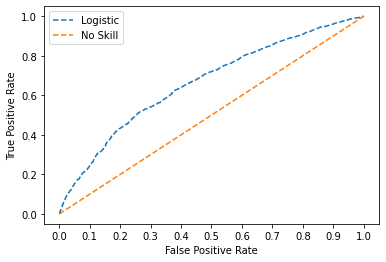

In [26]:
model_probs = logClassifier.predict_proba(valid_X)[:,1]
ns_probs = [0 for _ in range(len(valid_y))]

# calculate scores
model_auc = roc_auc_score(valid_y, model_probs)
ns_auc = roc_auc_score(valid_y, ns_probs)

# summarize scores
print('Logistic: ROC AUC=%.3f' % (model_auc))
print('No Skill: ROC AUC=%.3f' % (ns_auc))

# calculate roc curves
model_fpr, model_tpr, _ = roc_curve(valid_y, model_probs)
ns_fpr, ns_tpr, _ = roc_curve(valid_y, ns_probs)

# plot the roc curve for the model
plt.plot(model_fpr, model_tpr, linestyle='--', label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.xticks(np.arange(0, 1.1, .1))

# show the legend
plt.legend()
# show the plot
plt.show()

### Precision Recall Chart

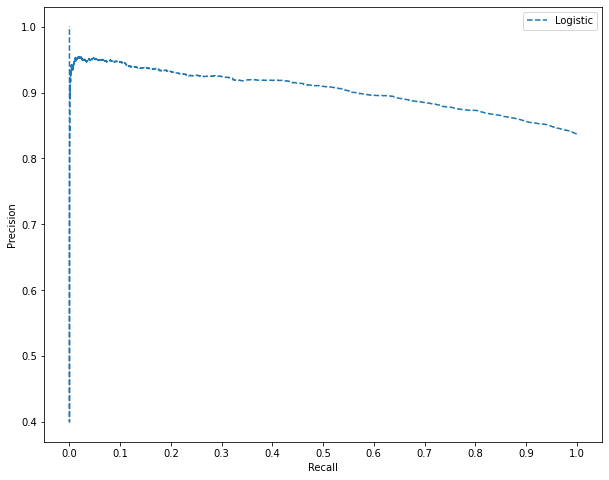

In [ ]:
precision, recall, thresholds = precision_recall_curve(valid_y, model_probs)

plt.figure(figsize=(10,8))

# plot the roc curve for the model
plt.plot(recall, precision, linestyle='--', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()


plt.xticks(np.arange(0, 1.1, .1))

# show the plot
plt.show()

### Model Performance

### Default model  (ie 50% Threshold)

In [ ]:
validation_predictions = logClassifier.predict(valid_X)
print('Confusion Matrix\n',confusion_matrix(valid_y, validation_predictions))
print('Accuracy :',accuracy_score(valid_y, validation_predictions))
print('Precision :',precision_score(valid_y, validation_predictions))
print('Recall:',recall_score(valid_y, validation_predictions))

Confusion Matrix
 [[    2 10392]
 [   10 53567]]
Accuracy : 0.837395069640931
Precision : 0.8375209118341438
Recall: 0.9998133527446479


## Decision Trees

In [53]:
# Criterion used to guide data splits
criterion = ['gini', 'entropy']

#Score measure optimizing for recall
score_measure = 'precision'

# Maximum number of levels in tree. If None, then nodes are expanded until all leaves are pure or until all 
# leaves contain less than min_samples_split samples.
# default = None
max_depth = [int(x) for x in np.linspace(5, 200, num = 40)]
max_depth.append(None)

# Minimum number of samples required to split a node
# default is 2
min_samples_split = [1, 3, 5, 8, 10, 15]

# Minimum number of samples required at each leaf node
# default = 1 
min_samples_leaf = [1, 2, 3, 4]

# max_leaf_nodes  - Grow trees with max_leaf_nodes in best-first fashion.
# If None then unlimited number of leaf nodes.
# default=None 
max_leaf_nodes = [None]

# min_impurity_decrease - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
# default=0.0
min_impurity_decrease = [0.000, 0.0005, 0.001, 0.005, 0.01]

# Create the random grid
param_grid_random = { 'criterion': criterion,
                      'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'min_samples_leaf' : min_samples_leaf,
                      'max_leaf_nodes' : max_leaf_nodes,
                      'min_impurity_decrease' : min_impurity_decrease
                     }


In [54]:
# Use the param_grid_random for an initial "rough" search using Randomized search
dtree_default = DecisionTreeClassifier(random_state=1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randomSearch = RandomizedSearchCV(estimator = dtree_default, param_distributions = param_grid_random, scoring=score_measure, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
randomSearch.fit(train_X, train_y)
bestRandomModel = randomSearch.best_estimator_
print('Best parameters found: ', randomSearch.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.1s finished


Best parameters found:  {'min_samples_split': 3, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_depth': 190, 'criterion': 'entropy'}


In [55]:
validation_predictions = bestRandomModel.predict(valid_X)
print('Accuracy Score: ', accuracy_score(valid_y, validation_predictions))
print('Precision Score: ', precision_score(valid_y, validation_predictions))
print('Recall Score: ', recall_score(valid_y, validation_predictions))
print('\nConfusion Matrix: \n',confusion_matrix(valid_y, validation_predictions))

Accuracy Score:  0.8164608410192278
Precision Score:  0.8712864237526478
Recall Score:  0.9156347038796813

Confusion Matrix: 
 [[ 3281  7231]
 [ 4510 48948]]


### Narrowing down

In [57]:
# let's take the best parameters from the the random search, and use this as a base for gridsearch
param_grid = {
              'min_samples_split': [1, 2, 3, 4, 5],  
              'min_samples_leaf': [0, 1, 2, 3, 4],
              'min_impurity_decrease': [0, 0.0001, 0.0002, 0.0003, 0.0004],
              'max_leaf_nodes': [None], 
              'max_depth': [150,170,190,210,220],
              'criterion': ['entropy'],
}

### Refined model (Using Grid CV)

In [58]:
# refine our search using param_grid
dtree_tuned = DecisionTreeClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gridSearch = GridSearchCV(estimator = dtree_tuned, param_grid=param_grid, cv = 3, scoring = score_measure, verbose=2,  n_jobs = -1)
# Fit the random search model
gridSearch.fit(train_X, train_y)
bestGridModel = gridSearch.best_estimator_
print('Best parameters found: ', gridSearch.best_params_)

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1213 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1658 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1875 out of 1875 | elapsed:   22.2s finished


Best parameters found:  {'criterion': 'entropy', 'max_depth': 210, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 3}


### Test of performance

In [59]:
validation_predictions = bestGridModel.predict(valid_X)
print('Accuracy score: ',accuracy_score(valid_y, validation_predictions))
print('Precision score: ',precision_score(valid_y, validation_predictions))
print('Recall score: ',recall_score(valid_y, validation_predictions))
print('Confusion matrix: \n',confusion_matrix(valid_y, validation_predictions))

Accuracy score:  0.8166171642957636
Precision score:  0.8713225479203375
Recall score:  0.9158030603464402
Confusion matrix: 
 [[ 3282  7230]
 [ 4501 48957]]


## XG BOOST 

### Parameters

In [ ]:
# Like with k-nn and decision trees, there are a number of hyperparamaters that can be explored 

# Number of trees in random forest; default is 100
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Learning rate
learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5]

# Maximum number of levels in tree. If None, then nodes are expanded until all leaves are pure or until all 
# leaves contain less than min_samples_split samples.
# default = None
max_depth = [int(x) for x in np.linspace(1, 200, num = 199)]
max_depth.append(None)



# Create the random grid
param_grid_random = {'n_estimators': n_estimators,
                      'max_depth': max_depth,
                      'learning_rate': learning_rate,
                     }



### Random Search

In [ ]:
# Use the param_grid_random for an initial "rough" search using Randomized search
xgb = XGBClassifier(randomstate=1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randomSearch = RandomizedSearchCV(estimator = xgb, param_distributions = param_grid_random, scoring = score_measure, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#randomSearch.fit(train_X, train_y,early_stopping_rounds=10)
randomSearch.fit(train_X, train_y)
bestRandomModel = randomSearch.best_estimator_
print('Best parameters found: ', randomSearch.best_params_)


Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 38.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed: 159.5min
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed: 288.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 451.9min finished


Best parameters found:  {'n_estimators': 800, 'max_depth': 13, 'learning_rate': 0.5}


### Performance

In [ ]:
validation_predictions = bestRandomModel.predict(valid_X)
print('Accuracy Score: ', accuracy_score(valid_y, validation_predictions))
print('Precision Score: ', precision_score(valid_y, validation_predictions))
print('Recall Score: ', recall_score(valid_y, validation_predictions))
print('Confusion Matrix: \n', confusion_matrix(valid_y, validation_predictions))


Accuracy Score:  0.8336277375685858
Precision Score:  0.8692802587215304
Recall Score:  0.9431845754708177
Confusion Matrix: 
 [[ 2795  7599]
 [ 3044 50533]]


## MLP

### Function for fitting and predicting

In [ ]:
def deeplearner(combination,tf=False):
  %%time
  print(10*'*',f'Combination {combination}',10*'*')
  print(27*'``')
  start = time.time()
  model = MLPClassifier(hidden_layer_sizes=combination, solver='adam', max_iter=200, verbose=tf, random_state=1)
  model.fit(train_X, train_y)

  end = time.time()
  print("Total Time", end - start)

  %%time

  start = time.time()
  validation_predictions = model.predict(valid_X)
  end = time.time()
  print("Total Time per prediction =", (end - start)/len(valid_X))


  print('Accuracy Score: ', accuracy_score(valid_y, validation_predictions))
  print('Precision Score: ', precision_score(valid_y, validation_predictions))
  print('Recall Score: ', recall_score(valid_y, validation_predictions))

### Tunning to find the best combination.

In [ ]:
#combinations = [(500,250,200),(500, 250, 200, 100),(900,500,300),(1500,450),(1200,),(900,),(600,),(450,)]
combinations = [(150,),(150,80),(150,80,20),(300,150,80),(300,150,80,20),(350,150)]
for combination in combinations:
  deeplearner(combination)
  print()
  print()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
********** Combination (150,) **********
``````````````````````````````````````````````````````
Total Time 195.9921190738678
CPU times: user 41 µs, sys: 160 µs, total: 201 µs
Wall time: 9.06 µs
Total Time per prediction = 1.9858872630888317e-06
Accuracy Score:  0.8360976067280487
Precision Score:  0.8389761178062364
Recall Score:  0.9953338186161973


CPU times: user 41 µs, sys: 156 µs, total: 197 µs
Wall time: 9.54 µs
********** Combination (150, 80) **********
``````````````````````````````````````````````````````
Total Time 592.4936769008636
CPU times: user 42 µs, sys: 165 µs, total: 207 µs
Wall time: 9.78 µs
Total Time per prediction = 2.669433862331021e-06
Accuracy Score:  0.8380047208891529
Precision Score:  0.8390929064657878
Recall Score:  0.9979468801911268


CPU times: user 34 µs, sys: 158 µs, total: 192 µs
Wall time: 9.3 µs
********** Combination (150, 80, 20) **********
`````````````````````````````````````````

In [ ]:
deeplearner((150, 80, 20))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
********** Combination (150, 80, 20) **********
``````````````````````````````````````````````````````
Total Time 772.8672544956207
CPU times: user 44 µs, sys: 182 µs, total: 226 µs
Wall time: 11 µs
Total Time per prediction = 4.318338857413631e-06
Accuracy Score:  0.8382079379718935
Precision Score:  0.8425765957109572
Recall Score:  0.9921981447262818


## KNN

In [ ]:
# create a standard scaler and fit it to the training set of predictors
scaler = preprocessing.StandardScaler()
scaler.fit(train_X)

# Transform the predictors of training, validation 
train_predictors = scaler.transform(train_X)
validation_predictors = scaler.transform(valid_X)

train_predictors=pd.DataFrame(train_predictors,columns=predictors)
validation_predictors=pd.DataFrame(validation_predictors,columns=predictors)

print(train_predictors)
print()
print(validation_predictors)
print()


        agricultureStructureIndicator  ...  occupancyType_4.0
0                           -0.021349  ...          -0.336470
1                           -0.021349  ...           2.972037
2                           -0.021349  ...           2.972037
3                           -0.021349  ...          -0.336470
4                           -0.021349  ...          -0.336470
...                               ...  ...                ...
149260                      -0.021349  ...          -0.336470
149261                      -0.021349  ...          -0.336470
149262                      -0.021349  ...          -0.336470
149263                      -0.021349  ...          -0.336470
149264                      -0.021349  ...          -0.336470

[149265 rows x 16 columns]

       agricultureStructureIndicator  ...  occupancyType_4.0
0                          -0.021349  ...          -0.336470
1                          -0.021349  ...          -0.336470
2                          -0.021349  ...   

In [ ]:
params_search = {'n_neighbors':range(1,round((math.sqrt(len(df)))),6)}
score_measure = 'precision'
knn = KNeighborsClassifier()
gridSearch = GridSearchCV(estimator = knn, param_grid=params_search, scoring = score_measure, verbose=1,cv=3,  n_jobs = -1)
gridSearch.fit(train_predictors, train_y)
bestGridModel = gridSearch.best_estimator_
print('Best parameters found: ', gridSearch.best_params_)

Fitting 3 folds for each of 77 candidates, totalling 231 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 27.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed: 52.1min finished


Best parameters found:  {'n_neighbors': 1}


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_predictors, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
validation_predictors = knn.predict(validation_predictors)
print('Accuracy :',accuracy_score(valid_y, validation_predictors))
print()
print('Recall :',recall_score(valid_y, validation_predictors))
print()
print('Precision :',precision_score(valid_y, validation_predictors))
print()
print(confusion_matrix(valid_y, validation_predictors))
print()

Accuracy : 0.7840115052132998

Recall : 0.8713067174347201

Precision : 0.870867845683158

[[ 3472  6922]
 [ 6895 46682]]



# Conclusion and recommendation

Our models seek to predict low risk opportunities to underwrite. 

False Positive (FP) indicates instances when the model classified the area as low risk (i.e. value of 1) when in fact it was high risk (i.e. value of 0 and loss above 50%).​ This is costly to the business since they end up paying out a higher amount than expected.

False Negative (FN) is an instance when the model classified the area as high risk (i.e. value of 0) when in fact it was low risk (i.e. value of 1 and loss below 50%)​. The business will lose the potential premiums. This will be less costly to the business compared to the cost of taking a higher risk than expected (FP).

Since the cost of a FP is greater than a FN negative, the business has to minimize FP and the best measure to optimize for FP is Precision score. The table below shows the performance of various models. 

</br><center> <b> COMPARISION OF PERFORMANCE </b> </center>

| Models    | Logistic | Decision Tree | XGBOOST  | MLP      | k-NN     |
|-----------|----------|---------------|----------|----------|----------|
| Precision | 83.7521% | 87.1322%      | 86.9280% | 84.2576% | 87.0867% |
| Accuracy  | 83.7395% | 81.6617%      | 83.3627% | 83.8207% | 78.4011% |

Looking at the table above, we  can see that the decision tree has the highest precision score of 87.1322% . The K-NN model has the precision score of 87.0867%, which is close to the precision score of decsion tree. However, Decision tree outperforms K-NN in terms of the accuracy score (81.6617 > 78.4011%). In addition, the decision tree model was significantly faster to run. Given how large the dataset is, speed is a very important feature. Hence, decision tree would be the recommended model. 